<a href="https://colab.research.google.com/github/fralfaro/clei2025-llm/blob/main/docs/dia2/notebooks/react-web-search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# LangGraph doing a web search plus sentiment analysis using ReAct

* Sign up to: https://app.tavily.com/home
* Tavily search tool: https://python.langchain.com/docs/integrations/tools/tavily_search

In [ ]:
# %%capture --no-stderr
# %pip install langchain langchain-openai langchain_experimental python-dotenv matplotlib numpy pandas langgraph langchain-community langchain_tavily

In [4]:
import json
from dotenv import load_dotenv

load_dotenv()

def pp(data):
    print(json.dumps(data, indent=2, default=str))


In [5]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=5,
    topic="general", # Can be "general", "news", or "finance"
    # include_answer=False,
    # include_raw_content=False,
    include_images=False,
    include_image_descriptions=False,
    search_depth="basic",
    time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [9]:
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent

llm = init_chat_model(
    "openai:gpt-5-nano"
)

# Decoramos nuestro llm con ReAct - Reason + Act
react_llm = create_react_agent(
    model=llm,
    tools=[tavily_search],
)

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    # ReAct usar `messages` para devolver el resultado de las tools que invoca
    response = react_llm.invoke({ "messages": [SystemMessage(content=prompt)] })

    return response

response = search_trending_topics({
    "user_query": "What are the latest trends in technology?",
    "refined_query": "Latest trends in technology",
    "trending_topics": "",
    "sentiment_analysis": ""
})

In [10]:
response

{'messages': [SystemMessage(content='\n    Given the refined user query, your job is to search for trending topics related to it.\n\n    Refined query: Latest trends in technology\n\n    Trending topics:', additional_kwargs={}, response_metadata={}, id='e430fda8-411c-4b93-9cda-e49eb86d50d7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gmcfxz5mjw0WKlsrlH5QX9EK', 'function': {'arguments': '{"query":"Latest trends in technology","time_range":"month","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 422, 'prompt_tokens': 1381, 'total_tokens': 1803, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CUMePhq1B0eQ44BuobutGMroRr8vC

In [11]:
response["messages"][-1].content.strip()

'Trending topics (latest month, based on major tech outlets)\n\n- Generative AI in business and productivity tools\n  - Rise of enterprise copilots, AI-assisted workflows, and AI-powered decision support across industries.\n  - Sources: Fortune Tech, Fast Company coverage of AI and tools.\n\n- AI governance, safety, and regulation\n  - Growing policy discussions and frameworks around AI safety, ethics, and accountability in the US and EU.\n  - Sources: FT Technology, Fortune coverage of policy trends.\n\n- AI hardware and semiconductor advances\n  - Advances in AI accelerators, chips, and the broader chip supply chain to support large-scale AI workloads.\n  - Sources: FT Technology, Fortune tech coverage.\n\n- Electric vehicles and autonomous driving tech\n  - Ongoing updates in EV demand, battery tech, and autonomous driving capabilities; notable recalls/updates in the sector.\n  - Sources: Fast Company tech news (e.g., EV/AV topics and recalls).\n\n- Cybersecurity and data privacy in

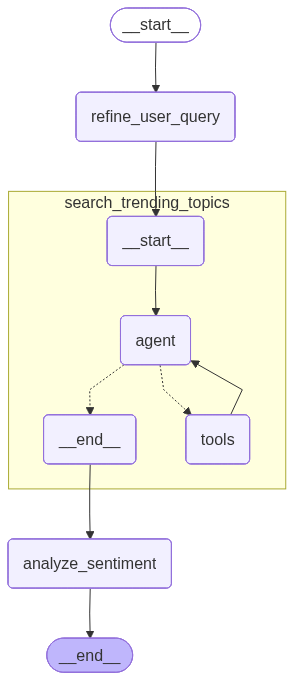

In [13]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model

from langgraph.prebuilt import create_react_agent

llm = init_chat_model(
    "openai:gpt-5-nano"
)

react_llm = create_react_agent(
    model=llm,
    tools=[tavily_search],
)

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def refine_user_query(state: TypedDictState) -> TypedDictState:
    user_query = state['user_query']

    prompt = f"""
    Given the user query, your job is to rewrite it to make it more specific and clear.

    User query: {user_query}

    Revised query:"""

    response = llm.invoke(prompt)

    return { "refined_query": response.content.strip() }

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = react_llm.invoke({ "messages": [SystemMessage(content=prompt)] })

    return { "trending_topics": response["messages"][-1].content.strip() }

def analyze_sentiment(state: TypedDictState) -> TypedDictState:

    trending_topics = state['trending_topics']

    prompt = f"""
    Given the trending topics, your job is to analyze their sentiment.

    Trending topics: {trending_topics}

    Sentiment analysis:"""

    response = llm.invoke(prompt)

    return { "sentiment_analysis": response.content.strip() }

builder = StateGraph(TypedDictState)

builder.add_node("refine_user_query", refine_user_query)
builder.add_node("search_trending_topics", search_trending_topics)
builder.add_node("analyze_sentiment", analyze_sentiment)

builder.add_edge(START, "refine_user_query")
builder.add_edge("refine_user_query", "search_trending_topics")
builder.add_edge("search_trending_topics", "analyze_sentiment")
builder.add_edge("analyze_sentiment", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

state = graph.invoke(input=initial_state)

In [15]:
state

{'user_query': 'Is people buying ETH on the last month?',
 'refined_query': 'Revised query: What was the total ETH buying volume in the last 30 days?',
 'trending_topics': 'Here are current trending topics and angles people are discussing around the query “What was the total ETH buying volume in the last 30 days?”\n\n- 30-day ETH trading volume context\n  - Market data often cites ETH daily trading volume in the tens of billions of dollars. For example, reports have mentioned daily volumes around $41B during the recent month, which is the closest public framing you’ll typically see for “buying volume” over a 30-day window (note: this is exchange-traded volume, not a strict “buying” metric).\n\n- Price action vs. volume\n  - ETH has seen a noticeable move over the past 30 days (roughly a mid-single-digit to high-single-digit percent change in various briefs). Trends in volume often accompany these moves, with spikes around rallies or pullbacks.\n\n- On-chain buy-pressure signals\n  - An

In [14]:
from IPython.display import Markdown, display

display(Markdown(f"**Sentiment Analysis:**\n\n{state['sentiment_analysis']}"))


**Sentiment Analysis:**

Here’s a sentiment snapshot of the trending ETH-buyers and purchase-volume topics:

Overall vibe:
- The narrative is broadly cautiously optimistic: demand signals (on-chain buyers, purchase volume, and network activity) are favorable, but progress is tempered by data-definition debates and mixed institution flows.

Topic-by-topic sentiment:
- ETH on-chain buyer activity trends (unique buyers in last 30 days): Positive to cautiously optimistic. Rising buying activity suggests growing demand, but sustainability and the exact definition of “buyers” are key caveats.
- Total ETH purchase volume over the last 30 days (on-chain buy-volume): Positive/optimistic when framed by volume growth, though context matters. Traders want clear buy-intensity signals, and data quality or methodology nuances can mute enthusiasm.
- Institutional demand signals for ETH (ETF/institutional flows, custody, large-trader activity): Mixed. Pro-inflow signals (e.g., ETF inflows) would be positive, while outflows or ambiguous institutional activity keep sentiment uncertain.
- ETH network activity vs price dynamics (daily transactions, gas usage, and price correlation): Positive. Higher network activity aligned with price moves is viewed as a supportive sign for demand and potential price momentum.
- Methodology and definitions debate (how “buyers” and “purchase volume” are defined on-chain): Neutral/uncertain. This topic dampens conviction because differing definitions can lead to apples-vs-oranges comparisons.

What to watch next (implications):
- If unique buyers and purchase-volume both rise with consistent definitions, sentiment tilts more bullish.
- If institutional flows pivot (e.g., sustained inflows) or outflows dominate, sentiment could flip toward caution or bearish risk-off sentiment.
- Ongoing debates on methodology will keep short-term interpretation ranges wide; standardized metrics will improve clarity and confidence.

If you want, I can pull current figures from specific sources (e.g., Glassnode, Santiment, Nansen) and provide:
- number of unique ETH buying addresses in the last 30 days
- total ETH purchased (in ETH and USD if available)
- a quick comparison to the prior 30 days
I can also tailor the sentiment to your preferred definitions (e.g., only buyers that initiate purchases vs. all addresses receiving ETH via purchases) and by data source.